In [1]:
import altair as alt
from load_data import load_data

In [2]:
alt.themes.enable('ggplot2')

ThemeRegistry.enable('ggplot2')

In [3]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [9]:
df = load_data().query('YEAR == 2018')

In [10]:
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,0,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,0,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,0,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,0,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,0,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [57]:
brush = alt.selection_interval(encodings=['x'], empty='all')
data = alt.Chart(df).properties(
    height=300,
    width=600
).transform_timeunit(month="yearmonth(OCCURRED_ON_DATE)")



# Offenses per month

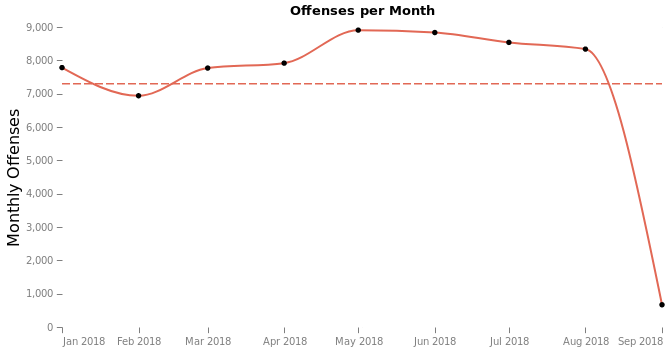

In [65]:
offenses_base = (
    data
    .properties(title="Offenses per Month")
    .transform_aggregate(num_offenses='count()', groupby=["month"])
)

offenses_line = (offenses_base
                 .encode(
                     x=alt.X("month:T", timeUnit="yearmonth", axis=alt.Axis(title=None)),
                     y=alt.Y("num_offenses:Q",scale=alt.Scale(zero=False), axis=alt.Axis(title="Monthly Offenses")),
                     tooltip=[alt.Tooltip("month:T", title="Date"),
                              alt.Tooltip("count()", title="Number of Offenses")])
                )


offenses_mean = (
    offenses_base
    .mark_rule(strokeDash=[8, 3])
    .transform_filter(brush)
    .encode(
        y="mean(num_offenses):Q",
        size=alt.value(1.5),
        color=alt.value("#e26855")
    )
)

num_monthly_offenses = offenses_line.mark_line(interpolate='monotone', color="#e26855").add_selection(brush) + offenses_line.mark_circle(color="black") + offenses_mean
num_monthly_offenses

In [70]:
shooting_base = (data
        .properties(title="Monthly Shootings")
        .transform_aggregate(
            number_of_shootings="sum(SHOOTING)",
            groupby=["month"])
       )

shootings = (shooting_base
             .mark_line(interpolate='monotone', color="#e26855")
             .encode(x=alt.X("month:T", timeUnit="yearmonth", axis=alt.Axis(title=None)),
                     y=alt.Y("number_of_shootings:Q", axis=alt.Axis(title="Shootings pr Month")),
                     tooltip=[alt.Tooltip("number_of_shootings:Q", title="Number of Shootings"),
                              alt.Tooltip("yearmonth(month)", title="Date")])
             
            )

shootings_mean_line = shooting_base.encode(
    y="mean(number_of_shootings):Q",
    color=alt.value("#e26855"),
    size=alt.value(1.5)
).mark_rule(strokeDash=[8, 3]).transform_filter(brush)


shootings_per_month =  shootings.add_selection(brush) + shootings.mark_circle(color="black") + shootings_mean_line

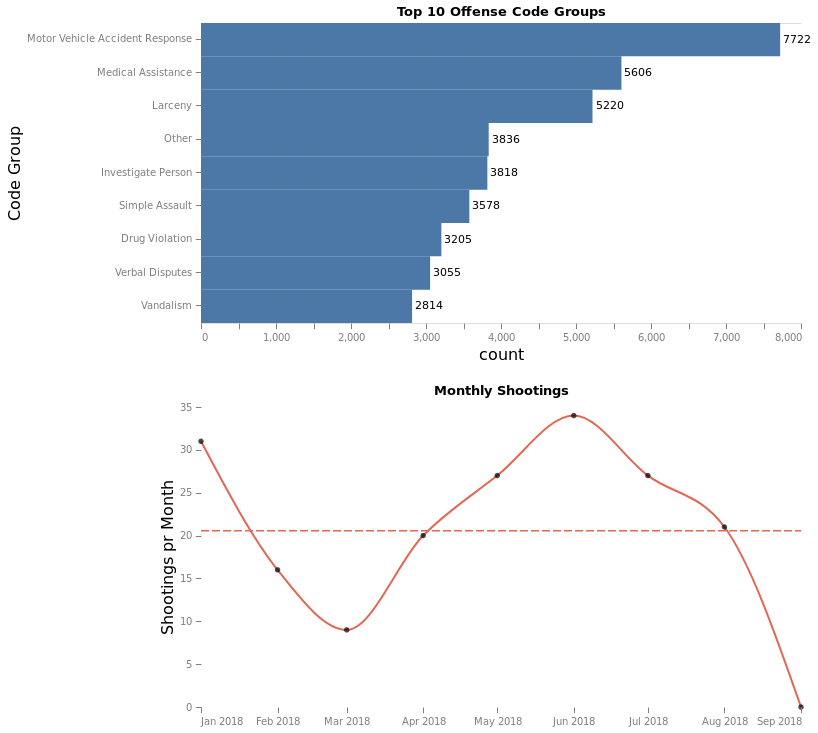

In [70]:
top10 = (data
         .properties(title="Top 10 Offense Code Groups")
         .transform_aggregate(
            count='count()',
            groupby=['OFFENSE_CODE_GROUP'])
         .transform_window(
             rank='rank(count)',
             sort=[alt.SortField('count', order='descending')])
         .transform_filter(alt.datum.rank < 10)
         .mark_bar()
         .encode(
             y=alt.Y('OFFENSE_CODE_GROUP:N', sort=alt.EncodingSortField(field='count', op='sum', order='descending'), title="Code Group"),
             x='count:Q')
        )

labels = top10.mark_text(
    baseline='middle',
    align='left',
    dx=3
).encode(
    text='count:Q'
)
top10_code_groups = labels + top10

In [ ]:
heatmap_base = (
    data
    .properties(title="Counts by Day and Hour", height=600, width=400)
    .transform_aggregate(
        num_offenses="count()",
        groupby=["HOUR", "DAY_OF_WEEK"]
    )
    .encode(
        x=alt.X("DAY_OF_WEEK:O", title="Day of Week"),
        y=alt.Y("HOUR:O", title="Hour of Day"),
        tooltip=[alt.Tooltip("DAY_OF_WEEK", title="Day of Week"),
                alt.Tooltip("HOUR", title="Hour of Day"),
                alt.Tooltip("num_offenses:Q", title="Number of Offenses")],
        color="num_offenses:Q"
))

heatmap = heatmap_base.mark_rect()
heatmap_text = heatmap_base.mark_text(baseline='middle').encode(
    text='num_offenses:Q',
    color=alt.condition(
        alt.datum.num_offenses < 1000,
        alt.value('black'),
        alt.value('white')
    )
)
day_hour_counts = heatmap + heatmap_text
day_hour_counts